## ***Summary of class/function for cell tracking***

* update some function, summarize related functions.


### Continue further on 2022/09/07.

* Yesterday, summarize up till the interactive segmentation part.
* continue through there.

### Continue on 2022/09/06.

* realized that the downstairs tracking computer doesn't start up: may need to get a new power supply?

* for now, don't need to check the scripts, but summarize each part of the script as a function.

* make it better as we update. Some of the functions can be grouped together as a class and we can specify the parameters in .yaml file.

### Updating from the:
20220823_Summarize_scripts_Select_cells_for_73D10_RedStinger_nompA

* just focus on the initial cell and ROI selection part, plus some associated scripts.

* then try to run it on the new google drive.
* for this, we move this sript to the new google drive as well.
* actually we will move it right now after this message, and make the same copy there.


### Yesterday has a notebook with all the info, here we will start cutting the un-necessary part, updating the scripts, remove the repetition of some analysis.

### Start combining the class for the cell tracking analysis.

* manually select the ROI.
* manually select the cell.
* watershed segmentation of the initial cells.
* track the cells.

### Copy the class and functions with description here first, then start putting them together.




### Connect to the google drive

In [ ]:
#link to the google drive. Need to follow the authorization instructions.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Define a class and functions for selecting an ROI
* we can't run the interactive ROI selection on the google colab, so we must test it somewhere else (it should work anyway). But we can test the other parts on the google drive as we combine other functions into this ROI selection class.

* change names on 20220822.
* Revised on 20220125 to include the max pixel value for displaying the average GFP images

In [ ]:
#import the necessary packages.
import numpy as np
import os
import fnmatch
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, center_of_mass
import pickle
from skimage.segmentation import watershed
from skimage.measure import regionprops_table
from skimage.measure import regionprops
from skimage.draw import ellipse
import cv2
import seaborn as sb
import pandas as pd
from ipywidgets import widgets
from ipywidgets import interact, interact_manual
#import display may need to change this part to deal with different scripts?
import IPython.display as Disp
from IPython.display import display
from itertools import compress


class roi_cell_select():
  %matplotlib notebook 


  def __init__(self,im,max_pixel):
    self.im = im
    self.max_pixel_value=max_pixel
    self.selected_points = []
    self.fig, ax = plt.subplots()
    self.img = ax.imshow(self.im.copy(), vmax=self.max_pixel_value)
    self.ka = self.fig.canvas.mpl_connect('button_press_event', self.onclick)
    disconnect_button = widgets.Button(description="Disconnect mpl")
    Disp.display(disconnect_button)
    disconnect_button.on_click(self.disconnect_mpl)


        
  def poly_img(self, img, pts):
    pts = np.array(pts, np.int32)
    pts = pts.reshape((-1,1,2))
    cv2.polylines(img, [pts], True, (255,255,255),1)
    return img

  def onclick(self, event):
    #display(str(event))
    self.selected_points.append([event.xdata, event.ydata])
    if len(self.selected_points)>1:
      self.fig
      self.img.set_data(self.poly_img(self.im.copy(), self.selected_points))
  def disconnect_mpl(self,_):
    self.fig.canvas.mpl_disconnect(self.ka)


#define a function for loading the files and return the necessary images;
def load_make_time_projection(filtered_file_path_G_sorted, filtered_file_path_R_sorted,
                              trial_number, start, end):
  #load the green signals
  with open(filtered_file_path_G_sorted[trial_number], "rb") as f:
    GFP_filtered=pickle.load(f)
  #load all red signals
  with open(filtered_file_path_R_sorted[trial_number], "rb") as f:
    RFP_filtered=pickle.load(f)

  #initialize ROI_masks for the green and red signals.
  ROI_masks_G=np.zeros((GFP_filtered.shape[0],GFP_filtered.shape[2],GFP_filtered.shape[3]),dtype=np.uint8)
  ROI_masks_R=np.zeros((RFP_filtered.shape[0],RFP_filtered.shape[2],RFP_filtered.shape[3]),dtype=np.uint8)
  
  #We have several z-levels in the GFP filtered images
  n_of_z=GFP_filtered.shape[0]

  #For each level average across the frames:
  #maybe change the range of averaging to show the position at the flexion and extension?
  average_GFP_filtered=np.mean(GFP_filtered[:,start:end,:,:],axis=1)
  average_RFP_filtered=np.mean(RFP_filtered[:,start:end,:,:],axis=1)
  
  #Show the GFP signals first
  fig,axs=plt.subplots(n_of_z,1,figsize=(8,20),tight_layout=True)

  #go through each z-level and show the aveage image at that z-level
  for z_level in range(average_GFP_filtered.shape[0]):
    axs[z_level].imshow(average_GFP_filtered[z_level,:,:],vmin=0,vmax=100)

  #then the Red signals
  fig,axs=plt.subplots(n_of_z,1,figsize=(8,20),tight_layout=True)

  #go through each z-level and show the aveage image at that z-level
  for z_level in range(average_RFP_filtered.shape[0]):
    axs[z_level].imshow(average_RFP_filtered[z_level,:,:],vmin=0,vmax=100)

  return {'green_signal':GFP_filtered, 'green_average':average_GFP_filtered,
          'red_signal':RFP_filtered, 'red_average':average_RFP_filtered,
          'mask_green':ROI_masks_G, 'mask_red':ROI_masks_R}

#Define a function for adding the ROI to the mask.
def add_to_mask(roi_polygon,ROI_masks_G,z_level,rows,columns):
  #Use the manually selected polygon to make the mask
  arr1 = np.array([roi_polygon.selected_points],'int')
  mask1 = cv2.fillPoly(np.zeros((rows,columns),np.uint8),arr1,[1,1,1])

  ROI_masks_G[z_level,:,:]=mask1

  return ROI_masks_G

#A function for saving the mask (after adding all the z-levels.)
def save_mask(ROI_masks,filtered_file_path_G_sorted,trial_number):
  ROI_masks=ROI_masks==1

  outfile=filtered_file_path_G_sorted[trial_number]+"_ROI_G_Z"

  with open(outfile, "wb") as f:
    pickle.dump(ROI_masks,f)
    
  print(outfile)
  print("trial_number = ", trial_number)
  return ROI_masks

#A function for making a mean projection with just the ROI
def make_mean_projection(n_of_z,rows,columns,ROI_masks,GFP_filtered,filtered_file_path_G_sorted,
                               trial_number):

  #Adjust the dimenstions so that we can broadcast the mask to the entire GFP_filtered
  #image series.
  new_masks=np.zeros((n_of_z,1,rows,columns))
  new_masks[:,0,:,:]=ROI_masks

  #From GFP_filtered data, keep only the regions selected by each z's masks
  GFP_filtered_masked=np.multiply(GFP_filtered,new_masks)

  #average intensity projection
  GFP_filtered_masked_mean_projection=np.mean(GFP_filtered_masked,axis=0)

  ### Save the GFP_filtered_masked_mean_projection and max projection
  outfile=filtered_file_path_G_sorted[trial_number]+"_Zprojection"

  with open(outfile, "wb") as f:
    pickle.dump([GFP_filtered_masked_mean_projection],f)
    
  print(outfile)
  return GFP_filtered_masked_mean_projection


#A function for making a video with the mean projection.
def make_video(GFP_filtered_masked_mean_projection, rows, columns, filtered_file_path_G_sorted,
                               trial_number, frames_per_second = 30, min_range = 0, max_range = 80):

  #make a video to see the entire data.
  #Number of frames
  total_frames=GFP_filtered_masked_mean_projection.shape[0]
  x_size=columns#number of columns
  y_size=rows#number of rows
    
  #Make a video with the mean projection
  video_name = (filtered_file_path_G_sorted[trial_number]+"video_gray.avi")
  #Image width will be 2 * imaging_width
  #Final "0" necessary for gray scale image
  video = cv2.VideoWriter(video_name,cv2.VideoWriter_fourcc(*'mp4v'),frames_per_second,(x_size,y_size),0)


  #For making video, all numbers below min_range will be treated as 0.
  #all numbers above max_range will be treated as max_range value.
  #Then normalize the image to be between 0 to 255.
  GFP_filtered_masked_mean_projection[GFP_filtered_masked_mean_projection<=min_range]=0
  GFP_filtered_masked_mean_projection[GFP_filtered_masked_mean_projection>=max_range]=max_range
  range_adjusted_GFP_filtered_masked_mean_projection=(GFP_filtered_masked_mean_projection/max_range)*255
    
  #Initialize the frame
  frame_original=np.zeros((y_size,x_size))

  for video_frame in range(total_frames):
    #Insert images in the right location.
    frame_original[:,0:x_size]=range_adjusted_GFP_filtered_masked_mean_projection[video_frame,:,:]

    frame=np.uint8(frame_original)
      
    video.write(frame)

  video.release()

#A function for converting and saving cell markers:
def convert_and_save_cell_markers(cell_marker,filtered_file_path_G_sorted,trial_number):
  #convert the selected points into integer coordinates.
  #First value is the x value (left is zero)
  #second value is the y value (top is zero)
  cell_markers = np.array([cell_marker.selected_points],'int')

  #Save the cell markers
  outfile_name=(filtered_file_path_G_sorted[trial_number]+"_cell_markers")
  with open(outfile_name, "wb") as f:
    pickle.dump(cell_markers,f)
  print(outfile_name)


#Functions for interactive segmentation.

#Following is a copy of the function right now.  
#Revised to not use the ROI.
#
#A function to flip the image, uses manually selected roi
#
#recommended threshold for this prep = 180.

def image_flip_for_watershed(data_matrix,frame_number,MaskThreshold):
  #without np.array, this function will modify the original data
  data_frame = np.array(data_matrix[frame_number,:,:])

  mask_for_thresholding = data_frame >= MaskThreshold
    
  #Make it a logical index
  mask_for_thresholding = mask_for_thresholding == 1
    
  #Just get the values for the masked region.
  data_frame_masked = data_frame[mask_for_thresholding]
  #Get the peak value for the masked region.
  peak_intensity=max(data_frame_masked)

  #Index for the background
  Background = data_frame < MaskThreshold

  #Flip the image intensity. Peak becomes zero. Background becomes peak intensity
  data_frame[mask_for_thresholding] = abs(data_frame[mask_for_thresholding] - peak_intensity)
  data_frame[Background] = peak_intensity

  return {'flipped_data':data_frame, 'mask_data':mask_for_thresholding}
    
def watershed_using_previous_marker_with_new_cluster_number(cell_markers, mask_image, extend_pixels, next_data):
  #Use cell_markers and extend to a square with extended_pixels in each direction
    
  #Get the row_values and column_values of the cell_markers as np.array
  #Find the number of cells (cell_markers.size = 2_values*n_of_cells)
  n_of_cells=cell_markers.size//2
  #Initialize the np array.
  row_values=np.zeros((n_of_cells,1),dtype=np.int16)
  column_values=np.zeros((n_of_cells,1),dtype=np.int16)
  #Get the row (0 is at the top) and column (0 is at the left edge) value for each cell
  for cell_n in range(n_of_cells):
    row_values[cell_n,0]=cell_markers[0,cell_n,1]
    column_values[cell_n,0]=cell_markers[0,cell_n,0]

  #Initialize the marker_matrix (which contains the marker as integers from 1 to n_of_cells)
  #We assume that the next_data has the same shape as the original data used for cell_markers
  marker_matrix=np.zeros((next_data.shape[0],next_data.shape[1]),dtype=np.int16)
       
  for cell_n in range(n_of_cells):
    #label has 0 for the background that we need to skip
    #make a marker for each cluster using centroid plus/minus "extend pixels"
    marker_matrix[row_values[cell_n,0]-extend_pixels:row_values[cell_n,0]+extend_pixels,column_values[cell_n,0]-extend_pixels:column_values[cell_n,0]+extend_pixels]=cell_n+1
        
  #Use the marker matrix and perform watershed segmentation on the next data
  next_labels = watershed(next_data,mask=mask_image,markers=marker_matrix)
  #
  return next_labels


#Revised to use the watershed_using_previous_marker_new_cluster_number
# Similar to the initial watershed segmentation, but uses previous labels.
#filtered_file_names.value,frame_number.value,threshold.value, cell_markers_file_names.value
def segmentation_with_cell_markers_independet_Z(infile_name,frame_number,mask_threshold, cell_markers_file, extend_pixels=5):
  #Load the file that contains both the max and mean projection.
  with open(infile_name, "rb") as f:
    [GFP_filtered_masked_mean_projection]=pickle.load(f)

  with open(cell_markers_file, "rb") as f:
    cell_markers = pickle.load(f)

  #We spcify the original mask threshold value in this function.
  threshold_value=mask_threshold

  #We use the mean projection for now, but we could use the max projection if necessary
  result_images = image_flip_for_watershed(GFP_filtered_masked_mean_projection,frame_number,threshold_value)
    
  #result_images contain both flipped_data and mask_data
  flipped_image=result_images['flipped_data']
  mask_image = result_images['mask_data']

  #Watershed using the cell_markers.
  labels_from_watershed = watershed_using_previous_marker_with_new_cluster_number(cell_markers, mask_image, extend_pixels, flipped_image)
  #Print out what are the labels (0 is for the background)
  print(np.unique(labels_from_watershed))
    
  #Show the overall clusters
  fig,ax=plt.subplots()
  im = ax.imshow(labels_from_watershed)
  # Remove axes and ticks
  plt.axis('off')
  plt.show()
    
  #Show the clusters one by one.
  #Show each index of the label in image
  for index in np.unique(labels_from_watershed):
    fig,ax=plt.subplots()
    im = ax.imshow(labels_from_watershed==index)
    # Remove axes and ticks
    plt.title(index)
    plt.axis('off')
    plt.show()
    
  #Return the labels
  return labels_from_watershed

# A function that merges a specified cluster with another cluster
#
#"cluster_to_merge" will have the same label as the "cluster_to_expand"
#Specify the label number for the cluster.
def merge_specified_cluster(input_labels_matrix, cluster_to_merge, cluster_to_expand):
  #necessary to keep the input_labels_matrix from changing 
  labels_matrix=np.array(input_labels_matrix)
    
  #replace the label for the "cluster_to_merge" with those for "cluster_to_expand"
  labels_matrix[labels_matrix==cluster_to_merge]=cluster_to_expand

  #Print out what are the labels (0 is for the background)
  print(np.unique(labels_matrix))
    
  #Show the overall clusters
  fig,ax=plt.subplots()
  im = ax.imshow(labels_matrix)
  # Remove axes and ticks
  plt.axis('off')
  plt.show()
    
  #Show the clusters one by one.
  #Show each index of the label in image
  for index in np.unique(labels_matrix):
    fig,ax=plt.subplots()
    im = ax.imshow(labels_matrix==index)
    # Remove axes and ticks
    plt.title(index)
    plt.axis('off')
    plt.show()
    
  return labels_matrix

#Modified to split the specified cluster at a specified ratio. split_ratio shows what fraction goes to the left side
#
#labels_matrix is labels that came out of the watershed segmentation.
#Background is labeld as 0.
def split_specified_cluster_ratio(input_labels_matrix, cluster_to_split, split_ratio):
  #necessary to keep the input_labels_matrix from changing 
  labels_matrix=np.array(input_labels_matrix)
    
  #Find the region properties. Use bbox to split the cluster (column wise)
  props_table=regionprops_table(labels_matrix,properties=['bbox'])
  #Shows the labels and their order
  label_order = np.unique(labels_matrix)
    
  #First find the cluster location.
  cluster_location=np.nonzero(label_order==cluster_to_split)
  cluster_location=cluster_location[0][0]
  #cluster location also includes background index, subtract 1 to get the correct index for bbox
  cluster_location=cluster_location-1
    
  #Get the bounding box column values and split it in the middle
  right_edge_values = props_table['bbox-3']
  left_edge_values = props_table['bbox-1']
        
  #Make a label matrix with 1s for the right side
  #and 0s for the left side of the bounding box
  split_labels=np.zeros((labels_matrix.shape[0],labels_matrix.shape[1]),dtype=np.int8)
  center_column=(left_edge_values[cluster_location])+np.rint((right_edge_values[cluster_location]-left_edge_values[cluster_location])*split_ratio)
  center_column=center_column.astype(int)
  #everyting right of center column is 1
  split_labels[:,center_column:]=1
        
        
  #For the right side of the cluster, change the label to one higher than the current max
  labels_matrix[(labels_matrix==cluster_to_split) & (split_labels==1)]=np.max(label_order)+1
               
  #Print out what are the labels (0 is for the background)
  print(np.unique(labels_matrix))
    
  #Show the overall clusters
  fig,ax=plt.subplots()
  im = ax.imshow(labels_matrix)
  # Remove axes and ticks
  plt.axis('off')
  plt.show()
    
  #Show the clusters one by one.
  #Show each index of the label in image
  for index in np.unique(labels_matrix):
    fig,ax=plt.subplots()
    im = ax.imshow(labels_matrix==index)
    # Remove axes and ticks
    plt.title(index)
    plt.axis('off')
    plt.show()
    
  return labels_matrix

# a function for plotting the femur_tibia_angle_image: circular mean of the femur tibia angle
# for each image frame. 
def plot_femur_tibia_angle_image(angle_input_file):
  #load the data from a pickled file
  infile=open(angle_input_file,'rb')
  [image_femur_tibia_angle] = pickle.load(infile)
  infile.close()

  plt.figure(figsize=(8,4))
  plt.plot(image_femur_tibia_angle)
  sb.despine()

#This section is for tracking the segmented cells.

#5th version: remove the condition that the neighbor has to decrease the value before adjusting the size.
#
#4th version: find all cells that have increased certain ratio above the
#average change in the cell size. Assumes that the cell size change in
#a similar manner as the cells get pulled during flexion.
#
#Third revision: find all cells that have increaed size above the threshold, adjust their size.
#
#Revised version checks if the cell with reduced or increased size is an isolated cell
#if it is don't try to adjust the edges.
#
#now check if the bbox length are in the correct range.
#
#Recommended value for the increase_threshold = 1.2 or lower
#decrease_threshold = 0.9

def check_cluster_size_adjust_labels(labels_matrix,bbox_width_original,index_for_clusters,increase_threshold, cluster_number):
    #define a buffer for the bbox to be next to each other.
    buffer=2
    #Make new np.array so we don't overwrite the original.
    new_labels=np.array(labels_matrix)
    #Get the centroid and bbox info
    props_table = regionprops_table(new_labels, properties=['centroid','bbox'])
    
    #Get the right and left edge of the bbox and check how much the width has changed from the original
    right_edge_values = props_table['bbox-3']
    left_edge_values = props_table['bbox-1']
    bbox_width=right_edge_values-left_edge_values
    width_ratio=bbox_width/bbox_width_original
    
    #find cells that are certain ratio above the average width_ratio.
    avg_width_ratio=np.mean(width_ratio)
 
    
    increased_width_index=width_ratio>increase_threshold*avg_width_ratio
    #check if any of the cell increased it's width
    if np.any(increased_width_index)==True:
        #Get the index for the cluster that increased.
        increased_cluster_index= list(compress(range(len(increased_width_index)),increased_width_index))
        
        #Now go through all the cell and adjust the size
        for cluster_number_index in increased_cluster_index:
            Increased_cluster=cluster_number_index
            #Bring back the oroginal bbox width.
        
            #Check the neighbor's ratio
            #There are two neighbors, unless we are at the edge.
            #First find the cluster location.
            cluster_location=np.nonzero(index_for_clusters==Increased_cluster)
            cluster_location=cluster_location[0][0]
        
            #If it's the first value then we only have one neighbor
            if cluster_location==0:
                neighbor_cluster_location =1
                #Index to show if the neigbor is to the right or left
                right_neighbor=1
        
            #Same with the last value
            elif cluster_location==cluster_number-1:
                neighbor_cluster_location = cluster_location-1
                right_neighbor=0
        
            #If it's in the middle then get the bbox width
            #For the one to the right and to the left and
            #chose one that is smaller.
        
            #See if the neighbor to the right is smaller than the left
            elif width_ratio[index_for_clusters[cluster_location+1]]<width_ratio[index_for_clusters[cluster_location-1]]:
                neighbor_cluster_location=cluster_location+1
                right_neighbor=1
        
            #Otherwise, the neighbor to the left is smaller
            else:
                neighbor_cluster_location=cluster_location-1
                right_neighbor=0
            
            
            #Go back to the average width ratio
            #Need to know if the neighbor to incerase is to the right or the left.
            if right_neighbor==1:
              #First make sure that the cell with the size change is not an isolated cell
              #defined as cell with bbox within "buffer" of each other.
              if (right_edge_values[index_for_clusters[cluster_location]]+buffer)>=left_edge_values[index_for_clusters[neighbor_cluster_location]]:
                #keep the left edge, move the right edge so it will
                #maintain the bbox width. Give the rest of the pixels
                #back to the shrunk neighbor cluster.
                    
                #Make a label matrix with zeros for the left side
                #and 1s for the right side of the new right edge
                split_labels=np.zeros((new_labels.shape[0],new_labels.shape[1]),dtype=np.int8)
                center_column=left_edge_values[index_for_clusters[cluster_location]]+(bbox_width_original[index_for_clusters[cluster_location]]*avg_width_ratio)
                #round the value to nearest integer and define as integer type to use as index
                center_column=np.rint(center_column)
                center_column=center_column.astype(int)
                #everyting right of center column is 1
                split_labels[:,center_column:]=1
        
                #label_order includes background so add 1 to the index
                max_area_index=index_for_clusters[cluster_location]+1
                neighbor_index=index_for_clusters[neighbor_cluster_location]+1
                label_order = np.unique(new_labels)
                max_cluster_label=label_order[max_area_index]
                neighbor_cluster_label=label_order[neighbor_index]
                #For right side of the max cluster, change the label to the neighbor cluster label
                new_labels[(new_labels==max_cluster_label) & (split_labels==1)]=neighbor_cluster_label
                        
                #if we change the cluster width, update the width information for the next increased cluster
                #Get the centroid and bbox info
                props_table = regionprops_table(new_labels, properties=['centroid','bbox'])
    
                #Get the right and left edge of the bbox and check how much the width has changed from the original
                right_edge_values = props_table['bbox-3']
                left_edge_values = props_table['bbox-1']
                bbox_width=right_edge_values-left_edge_values
                width_ratio=bbox_width/bbox_width_original
    
                        
            #Other wise the neighbor to increase is to the left of max_cluster
            else:
              #First make sure that the cell with the size change is not an isolated cell
              #defined as cell with bbox within "buffer" of each other.
              if (left_edge_values[index_for_clusters[cluster_location]]-buffer)<=right_edge_values[index_for_clusters[neighbor_cluster_location]]:
                #Keep the right edge of the max cluster,
                #maintain the bbox width for the max cluster,
                #Give the rest of the pixels back to the shrunk neighbor cluster.
                    
                #Make a label matrix with zeros for the left side
                #and 1s for the right side of the new right edge
                split_labels=np.zeros((new_labels.shape[0],new_labels.shape[1]),dtype=np.int8)
                center_column=right_edge_values[index_for_clusters[cluster_location]]-(bbox_width_original[index_for_clusters[cluster_location]]*avg_width_ratio)
                #round the value to nearest integer and define as integer type to use as index
                center_column=np.rint(center_column)
                center_column=center_column.astype(int)
                        
                #everyting left of center column is 1
                split_labels[:,:center_column]=1
        
                #label_order includes background so add 1 to the index
                max_area_index=index_for_clusters[cluster_location]+1
                neighbor_index=index_for_clusters[neighbor_cluster_location]+1
                label_order = np.unique(new_labels)
                max_cluster_label=label_order[max_area_index]
                neighbor_cluster_label=label_order[neighbor_index]
                #For left side of the max cluster, change the label to the neighbor cluster label
                new_labels[(new_labels==max_cluster_label) & (split_labels==1)]=neighbor_cluster_label
    
                #if we change the cluster width, update the width information for the next increased cluster
                #Get the centroid and bbox info
                props_table = regionprops_table(new_labels, properties=['centroid','bbox'])
    
                #Get the right and left edge of the bbox and check how much the width has changed from the original
                right_edge_values = props_table['bbox-3']
                left_edge_values = props_table['bbox-1']
                bbox_width=right_edge_values-left_edge_values
                width_ratio=bbox_width/bbox_width_original
    
        
    
    return new_labels




'''
A function that gives back an array that has cluster_id (the number that identifies the cluster), centroid row, centroid column, major_axis,
minor_axis, and orientation for each label frame. label_frame: a frame with labels
'''

def get_id_row_column_maj_min_ori(label_frame):
  #
  #need to know how many clusters we have. labels also have 0 for background so we will have a column for that as well
  cluster_number = len(np.unique(label_frame))-1
    
  #Also need to know the actual labels (sometime they are skipped), first one is 0 for background
  cluster_id=np.unique(label_frame)

  #Initialize
  id_row_column_maj_min_ori=np.zeros((cluster_number,6))
  for id in range(cluster_number):
    #
    #Check what the cluster number is for the centroid with lowest row, 2nd lowest row, etc
    test_label=label_frame==cluster_id[id+1]
    test_label=test_label.astype(int)
    props_table = regionprops_table(test_label, properties=['major_axis_length','minor_axis_length','orientation','centroid'])
    #Put in the matrix
    id_row_column_maj_min_ori[id,0]=cluster_id[id+1]
    id_row_column_maj_min_ori[id,1]=props_table['centroid-0']
    id_row_column_maj_min_ori[id,2]=props_table['centroid-1']
    id_row_column_maj_min_ori[id,3]=props_table['major_axis_length']
    id_row_column_maj_min_ori[id,4]=props_table['minor_axis_length']
    id_row_column_maj_min_ori[id,5]=props_table['orientation']

  return id_row_column_maj_min_ori




def watershed_using_previous_markers(initial_labels, mask_image, axis_ratio, min_size, next_data):
    #Use initial centroids and major and minor axis length to make a seed that is 1/axis_ratio the size
    #of an equivalent ellipse.
    #
    #Use initial_centroids and extend to a square with extended_pixels in each direction
    
    #We need the semi-axis so if the axis_ratio is x then we need to divide by 2x
    axis_ratio=axis_ratio*2

    #Get all the information together with the label number
    id_row_column_maj_min_ori = get_id_row_column_maj_min_ori(initial_labels)
     
    #Initialize marker matrix.
    marker_matrix=np.zeros((initial_labels.shape[0],initial_labels.shape[1]),dtype=np.uint8)
    
    #Go through for each cell
    for cell_order in range(id_row_column_maj_min_ori.shape[0]):
      #
      major_axis=id_row_column_maj_min_ori[cell_order,3]//axis_ratio
      if major_axis<min_size:
        major_axis=min_size
      minor_axis=id_row_column_maj_min_ori[cell_order,4]//axis_ratio
      if minor_axis<min_size:
        minor_axis=min_size

      #If the centroid is within major_axis of the border, shift the centroid
      #so the ellipse won't hit the border.
      if id_row_column_maj_min_ori[cell_order,1]<=major_axis:
        id_row_column_maj_min_ori[cell_order,1]=major_axis+1
      if id_row_column_maj_min_ori[cell_order,1]>=initial_labels.shape[0]-(major_axis+1):
        id_row_column_maj_min_ori[cell_order,1]=initial_labels.shape[0]-(major_axis+2)
      if id_row_column_maj_min_ori[cell_order,2]<=major_axis:
        id_row_column_maj_min_ori[cell_order,2]=major_axis+1
      if id_row_column_maj_min_ori[cell_order,2]>=initial_labels.shape[1]-(major_axis+1):
        id_row_column_maj_min_ori[cell_order,2]=initial_labels.shape[1]-(major_axis+2)
      

      rr,cc=ellipse(id_row_column_maj_min_ori[cell_order,1], id_row_column_maj_min_ori[cell_order,2],
                    minor_axis, major_axis,
                    rotation=id_row_column_maj_min_ori[cell_order,5])
      marker_matrix[rr,cc]=id_row_column_maj_min_ori[cell_order,0]

    #Use the marker matrix and perform watershed segmentation on the next data
    #This should work fine if the movments are slow.
    #If it is a fast motion, we should introduce momentum
    #In that case we would move the centroid by a certain amount based on previous movements.
    next_labels = watershed(next_data,mask=mask_image,markers=marker_matrix)
    #
    return next_labels





#We have this function in the other section, but keep here because this section works independently.
#May just put it in a class or module and import it later?
#
#Revised to not use the ROI.
#
#A function to flip the image, uses manually selected roi
#
#recommended threshold for this prep = 180.



#For now use the 9_z3 version; keep but not include here the 9_z4 version. Rename later.
#
#9_z3, revised to manually specify the threshold.
#
#9_z2, the version that uses the file that contains only the mean projection, instead of the mean projection and max projection.
#
#9_z, the version that uses the mean projection images that already accounts for the ROI specified at each z-level.
#
#9, the version that uses initial label made by the cell_markers and the resulting actual threshold value.
#
#8 the version that uses the watershed_using_previous_markers.
#
#7th version that uses the watershed_using_previous_marker2. And also the 5th version of the check
#
#6th version that performs the conversion for each frame.
#
#5th version that converts the threshold_percent to the actual threshold pixel value.
#
#A 4th version that uses the 4th version of the check_cluster_size, which adjust all cells that got certain ratio bigger than the average ratio
#
#A third version that uses the third version of the check_cluster_size, which adjusts all the cells larger than threshold
#
#A second version that uses the revised version of the check_cluster_size...
#
#Go through all the stacks and segment them into cells using watershed
#segmentation and the previous centroids as markers
#
#Recommended parameters
#extend pixels =12, increase_threshold = 1.2, decrease_threshold = 0.9

def stack_watershed_segmentation_markers_maxwidth_roi_projection(projection_image_file,labels_file, axis_ratio,min_size, increase_threshold, specified_threshold):
    
    #Load the mean projection images and the initial labels,
    #together with the theshold and the frame number parameters.

    #Load the file that contains both the max and mean projection.
    with open(projection_image_file, "rb") as f:
      [GFP_filtered_masked_mean_projection]=pickle.load(f)

    with open(labels_file, "rb") as f:
      initial_labels, initial_frame_number, threshold_percent = pickle.load(f)

    #need to know how many clusters we have.labels also have 0 for background so we will have a column for that as well
    cluster_number = len(np.unique(initial_labels))-1

    #Number of frames in the data
    total_frames = GFP_filtered_masked_mean_projection.shape[0]

    #initialize some data array
    all_labels=np.zeros((total_frames,initial_labels.shape[0],initial_labels.shape[1]),np.uint8)
    centroid_row_values=np.zeros((total_frames,cluster_number))
    centroid_column_values = np.zeros((total_frames, cluster_number))

    #first go towards the end.
    label_input = initial_labels
    frame_number = initial_frame_number

    #Place initial values. May be make this a function as well?
    props_table = regionprops_table(initial_labels, properties=['centroid','bbox'])
    centroid_row_values[frame_number,:]=props_table['centroid-0']
    centroid_column_values[frame_number,:]=props_table['centroid-1']
    all_labels[frame_number,:,:]=initial_labels

    #Get the index on how the clusters are ordered
    #Use to move the lines between the neighboring clusters.
    index_for_clusters=np.argsort(centroid_column_values[frame_number,:])

    #Get the bounding box column values
    right_edge_values = props_table['bbox-3']
    left_edge_values = props_table['bbox-1']
    #Try to keep this width constant through out the trial.
    bbox_width_original=right_edge_values-left_edge_values

    frame_number = frame_number+1

    while frame_number < total_frames:
        #For now, we just use the specified threshold value for all frames.
        #currently it's not percentage but the actual threshold pixel value.
        #Now calculate the threshold for each frame
        
        #Calculate the actual value for the threshold_percent % of the brightest pixels.
        #data_frame=np.array(tdTomato_Filtered[frame_number,:,:])
        #without np.array, this function will modify the original data
        #selected_pixels=data_frame[roi_matrix==1]
        #selected_pixels_sorted=sorted(selected_pixels)
        #get the index for the mask_threshold percentage of brightest pixels
        #threshold_index=np.floor(threshold_percent*len(selected_pixels_sorted)/100).astype(int)
        #threshold_value=selected_pixels_sorted[-threshold_index]
        
        #Comment this out and just manually specify here for now
        #MaskThreshold = threshold_percent
        MaskThreshold = specified_threshold

        #First get the next frame processed for the watershed segmentation.
        result_images = image_flip_for_watershed(GFP_filtered_masked_mean_projection,frame_number,MaskThreshold)
    
        #result_images contain both flipped_data and mask_data
        flipped_image=result_images['flipped_data']
        mask_image = result_images['mask_data']

        #Watershed using the previous labels
        new_labels = watershed_using_previous_markers(label_input, mask_image, axis_ratio, min_size,flipped_image)
        if len(np.unique(new_labels))<cluster_number+1:
            print(frame_number)
            break
        else:
            #Check the cluster size and adjust them if any got too big.
            new_labels_adjusted = check_cluster_size_adjust_labels(new_labels,bbox_width_original,index_for_clusters,increase_threshold, cluster_number)
            new_labels=new_labels_adjusted
            #Recalculate with the new "new_labels"        
            props_table = regionprops_table(new_labels, properties=['centroid','bbox'])
        
            if len(np.unique(new_labels))<cluster_number+1:
            
                print(frame_number)
                break
        
            centroid_row_values[frame_number,:]=props_table['centroid-0']
            centroid_column_values[frame_number,:]=props_table['centroid-1']
            all_labels[frame_number,:,:]=new_labels
            
        #Move to next frame
        frame_number = frame_number +1
        label_input=new_labels
    
    #now go backwards to the first frame.
    label_input = initial_labels
    frame_number = initial_frame_number


    frame_number = frame_number-1

    while frame_number >= 0:
        #Now calculate the threshold for each frame
        
        #Calculate the actual value for the threshold_percent % of the brightest pixels.
        #data_frame=np.array(tdTomato_Filtered[frame_number,:,:])
        #without np.array, this function will modify the original data
        #selected_pixels=data_frame[roi_matrix==1]
        #selected_pixels_sorted=sorted(selected_pixels)
        #get the index for the mask_threshold percentage of brightest pixels
        #threshold_index=np.floor(threshold_percent*len(selected_pixels_sorted)/100).astype(int)
        #threshold_value=selected_pixels_sorted[-threshold_index]
        #MaskThreshold = threshold_percent
        MaskThreshold = specified_threshold

        #First get the next frame processed for the watershed segmentation.
        result_images = image_flip_for_watershed(GFP_filtered_masked_mean_projection,frame_number,MaskThreshold)
        #result_images contain both flipped_data and mask_data
        flipped_image=result_images['flipped_data']
        mask_image = result_images['mask_data']

        #Watershed using the previous labels
        new_labels = watershed_using_previous_markers(label_input, mask_image, axis_ratio, min_size,flipped_image)
        if len(np.unique(new_labels))<cluster_number+1:
            print(frame_number)
            break
        else:
            #Check the cluster size and adjust them if any got too big.
            new_labels_adjusted = check_cluster_size_adjust_labels(new_labels,bbox_width_original,index_for_clusters,increase_threshold, cluster_number)
            new_labels=new_labels_adjusted
            #Recalculate with the new "new_labels"        
            props_table = regionprops_table(new_labels, properties=['centroid','bbox'])
        
            if len(np.unique(new_labels))<cluster_number+1:
            
                print(frame_number)
                break
        
            centroid_row_values[frame_number,:]=props_table['centroid-0']
            centroid_column_values[frame_number,:]=props_table['centroid-1']
            all_labels[frame_number,:,:]=new_labels
    
    
        #Move to next frame
        frame_number = frame_number -1
        label_input=new_labels
    
    #Save the all_labels
    outfile_name=(labels_file+"_all")
    with open(outfile_name, "wb") as f:
      pickle.dump(all_labels,f)
    
    
    video_file_name=(labels_file+"_video.avi")
    video = cv2.VideoWriter(video_file_name,cv2.VideoWriter_fourcc(*'mp4v'),30,(all_labels.shape[2],all_labels.shape[1]))
    #Go through all the frames.
    for video_frame in range(all_labels.shape[0]):
        #normalize the range
        new_labels=all_labels[video_frame,:,:]*(255//(cluster_number+1))
        frame = cv2.applyColorMap(np.uint8(new_labels),cv2.COLORMAP_JET)
        video.write(frame)

    video.release()

### To access the shared data to run the analyses online on google colab (excluding the interactive ROI/cell selection that needs to be done locally)
* go find "Tuthill Lab Shared/shared_data/2022_Biomechanics" folder in the google drive.
* right click on the folder and select "add shortcut".
* select the location on "My Drive" to place the shortcut.
* change the path below to the path to the shortcut.

In [ ]:

path = '/content/drive/MyDrive/Analysis/2022_Biomechanics/cell_tracking/'
#Get the file path to the GFP filtered data
filtered_file_path_G=[]

#Go through all the files in a directory
for file_name in os.listdir(path):
    if fnmatch.fnmatch(file_name,'*GCaMP_Filtered_Zs'):
        filtered_file_path_G.append(os.path.join(path,file_name))
        
filtered_file_path_G_sorted=sorted(filtered_file_path_G)

#Print to make sure
for f in filtered_file_path_G_sorted:
    print(f)

print(len(filtered_file_path_G_sorted))

/content/drive/MyDrive/Analysis/2022_Biomechanics/cell_tracking/Copy of Copy of Copy of 20220228-1-73D10-RedStinger-nompA-GFP_00004GCaMP_Filtered_Zs
1


In [ ]:
#Get the file path to the Red signal data
filtered_file_path_R=[]

#Go through all the files in a directory
for file_name in os.listdir(path):
    if fnmatch.fnmatch(file_name,'*tdTomato_Filtered_Zs'):
        filtered_file_path_R.append(os.path.join(path,file_name))
        
filtered_file_path_R_sorted=sorted(filtered_file_path_R)

#Print to make sure
for f in filtered_file_path_R_sorted:
    print(f)

print(len(filtered_file_path_R_sorted))

/content/drive/MyDrive/Analysis/2022_Biomechanics/cell_tracking/Copy of Copy of Copy of 20220228-1-73D10-RedStinger-nompA-GFP_00004tdTomato_Filtered_Zs
1


### Load the files and average in time for the entire 500 frames.


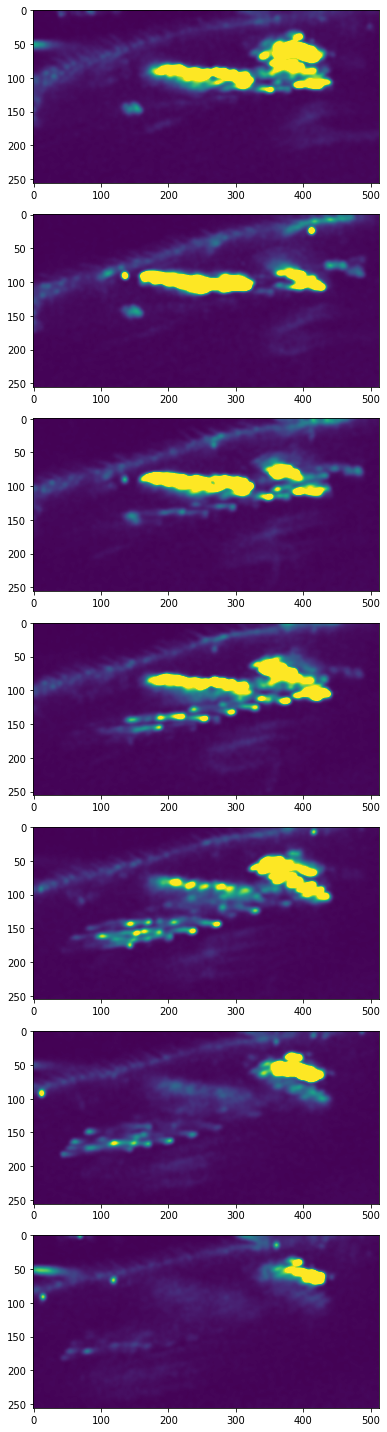

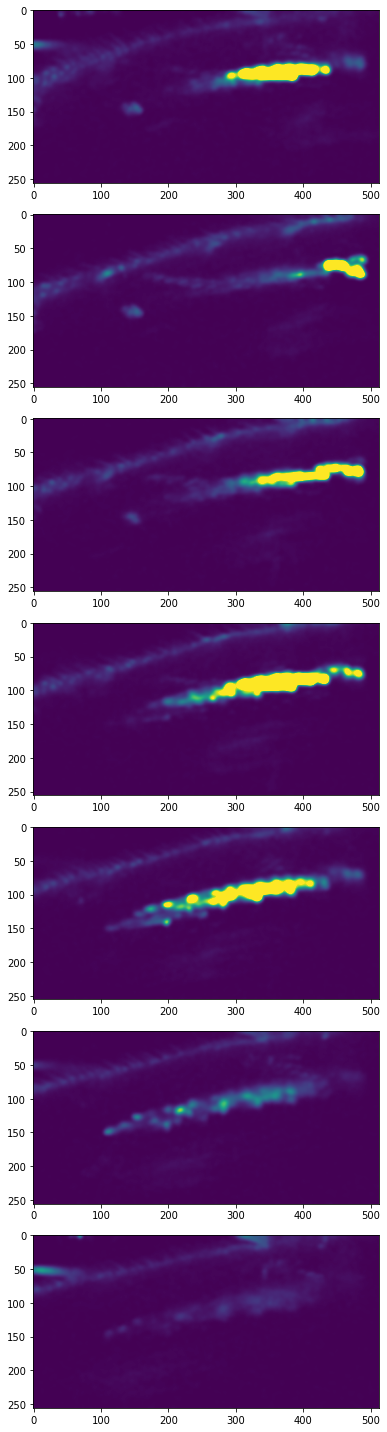

In [ ]:
%matplotlib inline
results = load_make_time_projection(filtered_file_path_G_sorted, filtered_file_path_R_sorted,0,0,500)

### at each z-level, select ROI for the GFP channel
* It won't work online

select the ROI


Button(description='Disconnect mpl', style=ButtonStyle())

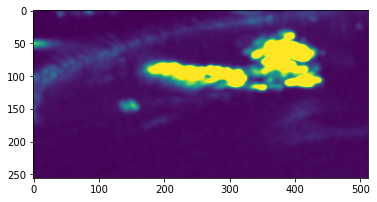

In [ ]:
z_level=0
#select ROI
print('select the ROI')
roi_polygon=roi_cell_select(results['green_average'][z_level,:,:],80)

In [ ]:
roi_polygon.selected_points=[[10,10],[250,10],[10,500],[250,500]]

### Add the manually selected ROI to the mask.
* this is for z-level = 0. (above).
* for this web version, we have manually entered the ROI (as above).

In [ ]:
ROI_masks_G = add_to_mask(roi_polygon, results['mask_green'],z_level,results['green_average'].shape[1],results['green_average'].shape[2])

### After repeating for all z-levels, convert to logical array and save the ROI_masks.

* do the same for the red channel as well.

In [ ]:
%matplotlib inline
ROI_masks = save_mask(ROI_masks_G,filtered_file_path_G_sorted,0)

/content/drive/MyDrive/Analysis/test/ROI_files_test/Copy of Copy of 20220228-1-73D10-RedStinger-nompA-GFP_00004GCaMP_Filtered_Zs_ROI_G_Z
trial_number =  0


### Make a mean intensity projection image series using just the ROI and make a video

* use for checking the results

In [ ]:
mean_projection = make_mean_projection(7,results['green_average'].shape[1],results['green_average'].shape[2],
                           ROI_masks,results['green_signal'],filtered_file_path_G_sorted,
                               0)


/content/drive/MyDrive/Analysis/test/ROI_files_test/Copy of Copy of 20220228-1-73D10-RedStinger-nompA-GFP_00004GCaMP_Filtered_Zs_Zprojection


### Using the same roi_cell_select to interactively select the positions of the cells. 

select the cell markers


Button(description='Disconnect mpl', style=ButtonStyle())

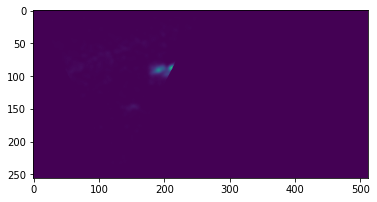

In [ ]:
%matplotlib inline
print('select the cell markers')
cell_marker=roi_cell_select(mean_projection[10,:,:],200)


In [ ]:
cell_marker.selected_points = [[[143, 175],[150, 165], [154, 156], [170, 166], [170, 142]]]

### Convert and save the cell markers

In [ ]:
convert_and_save_cell_markers(cell_marker,filtered_file_path_G_sorted,0)

/content/drive/MyDrive/Analysis/test/ROI_files_test/Copy of Copy of 20220228-1-73D10-RedStinger-nompA-GFP_00004GCaMP_Filtered_Zs_cell_markers


### Test the above on a desktop running linux with python 3.

* improve by putting the functions in a class, so we don't need to repeatedly specify some of the parameters. use .yaml file.

* during the actual analysis, make marks for other frames as well. Repeat the same procedures for the 250th and the last frame.

* Also do the same for the claw cells.

### Next section is for interactive watershed segmentation of the intial frame.

* currently a summary of all the functions.

* may summarize as a class and use .yaml to read in the parameters; howerver, because this is an interactive step where we change the threshold parameters to find the optimum values, it may be best to keep it as is.

### Get the file path for the nompA-GFP images, claw-RedStringer images, and cell markers.

* Make a test directory and run it.

In [ ]:
#Get the file path to the projected image sequences

projected_image_file_path=[]
#Path for the image files
path = '/content/drive/MyDrive/Analysis/test/Biomechanics_test/Interactive_watershed_segmentation/'

#Go through all the files in a directory (probably includes subidirectoies as well?)
for file_name in os.listdir(path):
    if fnmatch.fnmatch(file_name,'*_Zprojection'):
        projected_image_file_path.append(os.path.join(path,file_name))
        
projected_image_file_path_sorted=sorted(projected_image_file_path)

#Print to make sure
for f in projected_image_file_path_sorted:
    print(f)
    


/content/drive/MyDrive/Analysis/test/Biomechanics_test/Interactive_watershed_segmentation/Copy of Copy of 20220228-1-73D10-RedStinger-nompA-GFP_00005GCaMP_Filtered_Zs_Zprojection
/content/drive/MyDrive/Analysis/test/Biomechanics_test/Interactive_watershed_segmentation/Copy of Copy of 20220228-1-73D10-RedStinger-nompA-GFP_00005tdTomato_Filtered_Zs_Zprojection


### Currently, we shouldn't need the ROI files path.

In [ ]:
#Get the file path to the ROI file.

ROI_files_path=[]

#Go through all the files in a directory (probably includes subidirectoies as well?)
for file_name in os.listdir(path):
    if fnmatch.fnmatch(file_name,'*_ROI_Z'):
        ROI_files_path.append(os.path.join(path,file_name))
        
ROI_files_path_sorted=sorted(ROI_files_path)

#Print to make sure
for f in ROI_files_path_sorted:
    print(f)

In [ ]:
#Get the file path to the femur_tibia_angle_image file.

angle_files_path=[]


#Go through all the files in a directory (probably includes subidirectoies as well?)
for file_name in os.listdir(path):
    if fnmatch.fnmatch(file_name,'*adjusted_image'):
        angle_files_path.append(os.path.join(path,file_name))
        
angle_files_path_sorted=sorted(angle_files_path)

#Print to make sure
for f in angle_files_path_sorted:
    print(f)

/content/drive/MyDrive/Analysis/test/Biomechanics_test/Interactive_watershed_segmentation/Copy of Copy of Basler_acA800-510um__22190106__20220228_154312452_tibia_angle_adjusted_image


### Should not need Filtered_labels files

In [ ]:
#Get the file path to all the "_labels" files in the directory.

labels_files_path=[]


#Go through all the files in a directory (probably includes subidirectoies as well?)
for file_name in os.listdir(path):
    if fnmatch.fnmatch(file_name,'*Filtered_labels*'):
        labels_files_path.append(os.path.join(path,file_name))
        
labels_files_path_sorted=sorted(labels_files_path)

#Print to make sure
for f in labels_files_path_sorted:
    print(f)

### We have up to three markers, all at 250th frame, but for different brightness.

In [ ]:
#Get the file path to all the "_cell_markers" files in the directory.

cell_markers_files_path=[]


#Go through all the files in a directory (probably includes subidirectoies as well?)
for file_name in os.listdir(path):
    if fnmatch.fnmatch(file_name,'*_cell_markers*'):
        cell_markers_files_path.append(os.path.join(path,file_name))
        
cell_markers_files_path_sorted=sorted(cell_markers_files_path)

#Print to make sure
for f in cell_markers_files_path_sorted:
    print(f)

/content/drive/MyDrive/Analysis/test/Biomechanics_test/Interactive_watershed_segmentation/Copy of Copy of 20220228-1-73D10-RedStinger-nompA-GFP_00005GCaMP_Filtered_Zs_Zprojection_cell_markers_bright
/content/drive/MyDrive/Analysis/test/Biomechanics_test/Interactive_watershed_segmentation/Copy of Copy of 20220228-1-73D10-RedStinger-nompA-GFP_00005GCaMP_Filtered_Zs_Zprojection_cell_markers_dim
/content/drive/MyDrive/Analysis/test/Biomechanics_test/Interactive_watershed_segmentation/Copy of Copy of 20220228-1-73D10-RedStinger-nompA-GFP_00005GCaMP_Filtered_Zs_Zprojection_cell_markers_medium_without
/content/drive/MyDrive/Analysis/test/Biomechanics_test/Interactive_watershed_segmentation/Copy of Copy of 20220228-1-73D10-RedStinger-nompA-GFP_00005tdTomato_Filtered_Zs_Zprojection_cell_markers_brighter
/content/drive/MyDrive/Analysis/test/Biomechanics_test/Interactive_watershed_segmentation/Copy of Copy of 20220228-1-73D10-RedStinger-nompA-GFP_00005tdTomato_Filtered_Zs_Zprojection_cell_markers

### For green signal (labeled as GCaMP right now) and red signal (labeled as tdTomato right now).

In [ ]:
#Refresh the file path to all the "_labels" files in the directory.

labels_files_path=[]


#Go through all the files in a directory (probably includes subidirectoies as well?)
for file_name in os.listdir(path):
    if fnmatch.fnmatch(file_name,'*_labels*'):
        labels_files_path.append(os.path.join(path,file_name))
        
labels_files_path_sorted=sorted(labels_files_path)

#Print to make sure
for f in labels_files_path_sorted:
    print(f)

/content/drive/MyDrive/Analysis/test/Biomechanics_test/Interactive_watershed_segmentation/Copy of Copy of 20220228-1-73D10-RedStinger-nompA-GFP_00005GCaMP_Filtered_Zs_Zprojection_labels
/content/drive/MyDrive/Analysis/test/Biomechanics_test/Interactive_watershed_segmentation/Copy of Copy of 20220228-1-73D10-RedStinger-nompA-GFP_00005GCaMP_Filtered_Zs_Zprojection_labels2
/content/drive/MyDrive/Analysis/test/Biomechanics_test/Interactive_watershed_segmentation/Copy of Copy of 20220228-1-73D10-RedStinger-nompA-GFP_00005GCaMP_Filtered_Zs_Zprojection_labels2_all
/content/drive/MyDrive/Analysis/test/Biomechanics_test/Interactive_watershed_segmentation/Copy of Copy of 20220228-1-73D10-RedStinger-nompA-GFP_00005GCaMP_Filtered_Zs_Zprojection_labels2_video.avi
/content/drive/MyDrive/Analysis/test/Biomechanics_test/Interactive_watershed_segmentation/Copy of Copy of 20220228-1-73D10-RedStinger-nompA-GFP_00005GCaMP_Filtered_Zs_Zprojection_labels3
/content/drive/MyDrive/Analysis/test/Biomechanics_te

### This is the interactive version that read in the file that has only the mean projection that already incorporate the ROI at each z-level.

* for the previous claw cell tracking, we had the ROI file and a z-projection file without the ROI selection.

* this version should be better, and all the functions are still here.



In [ ]:
#we need this inorder to work online.
%matplotlib inline

Dropdown(options=('/content/drive/MyDrive/Analysis/test/Biomechanics_test/Interactive_watershed_segmentation/C…

Dropdown(options=('/content/drive/MyDrive/Analysis/test/Biomechanics_test/Interactive_watershed_segmentation/C…

Dropdown(options=('/content/drive/MyDrive/Analysis/test/Biomechanics_test/Interactive_watershed_segmentation/C…

Button(description='plot femur-tibia angle', layout=Layout(width='50%'), style=ButtonStyle())

Specify the threshold (actual value)


IntText(value=0)

Specify the frame number


IntText(value=0)

Button(description='Segmentation with cell markers', layout=Layout(width='50%'), style=ButtonStyle())

cluster to merge


IntText(value=0)

join to this cluster


IntText(value=0)

Button(description='merge clusters', style=ButtonStyle())

cluster to split


IntText(value=0)

Specify the split percentage


IntText(value=0)

Button(description='split clusters', style=ButtonStyle())

Button(description='save labels', style=ButtonStyle())

Button(description='save labels 2', style=ButtonStyle())

Button(description='save labels 3', style=ButtonStyle())

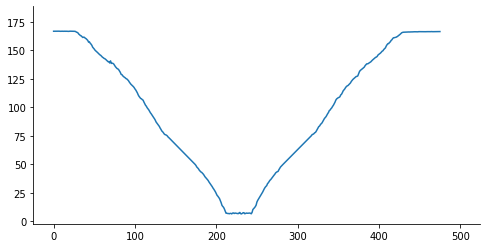

In [ ]:
#Make a drop down menu to select the file
filtered_file_names=widgets.Dropdown(options=projected_image_file_path_sorted)
display(filtered_file_names)

#In this version we don't need the ROI files (20220126)
#Another drop down menu for the ROI file
#roi_file_names=widgets.Dropdown(options=ROI_files_path_sorted)
#display(roi_file_names)

#Another drop down menu for the femur_tibia_angle_image file
angle_file_names=widgets.Dropdown(options=angle_files_path_sorted)
display(angle_file_names)

#Another drop down menu for the cell markers file
cell_markers_file_names=widgets.Dropdown(options=cell_markers_files_path_sorted)
display(cell_markers_file_names)

#A button for plotting the femur_tibia_angle_image.
plot_angle_button = widgets.Button(description="plot femur-tibia angle",layout=widgets.Layout(width='50%'))
display(plot_angle_button)

#A output for the current segmentation
output_segmentation=widgets.Output()

#A function that gets executed when "plot_angle_button" is clicked
def on_plot_angle(b):
    global angle_file_names
    #clear the output so we can refresh
    output_segmentation.clear_output()
    with output_segmentation:
        #plot the angles
        plot_femur_tibia_angle_image(angle_file_names.value)
        #return initial_labels
    
#Specify what happens when the "plot_angle_button" is clicked.
plot_angle_button.on_click(on_plot_angle)

#Make a box to specify the threshold (integer)
print('Specify the threshold (actual value)')
threshold=widgets.IntText()
display(threshold)

#Make another box to specify the frame number
print('Specify the frame number')
frame_number=widgets.IntText()
display(frame_number)

#A button for running the segmetation based on cell_markers.
segmentation_with_previous_label_button = widgets.Button(description="Segmentation with cell markers",layout=widgets.Layout(width='50%'))
display(segmentation_with_previous_label_button)

#A function that gets executed when "segmentaion_with_previous_label_button" is clicked
def on_segmentation_with_previous_label(b):
    global filtered_file_names,threshold,frame_number, initial_labels, cell_markers_file_names
    #clear the output so we can refresh
    output_segmentation.clear_output()
    with output_segmentation:
        #make the initial labels
        initial_labels=segmentation_with_cell_markers_independet_Z(filtered_file_names.value,frame_number.value,threshold.value, cell_markers_file_names.value)
        #return initial_labels
    
#Specify what happens when the "segmentation_with_previous_label_button" is clicked.
segmentation_with_previous_label_button.on_click(on_segmentation_with_previous_label)




#Make a box to specify the cluster to merge (integer)
print('cluster to merge')
merge_cluster=widgets.IntText()
display(merge_cluster)

#Make another box to specify the cluster to merge to
print('join to this cluster')
join_to_cluster=widgets.IntText()
display(join_to_cluster)

#make a button form merging the specified clusters.
merge_cluster_button = widgets.Button(description="merge clusters")
display(merge_cluster_button)

#define a function that gets executed when "merge_cluster_button" is clicked 
def on_merge_cluster_button_clicked(b):
    global initial_labels, merge_cluster, join_to_cluster
    #Clear output to refresh
    output_segmentation.clear_output()
    with output_segmentation:
        #Merge the specified clusters
        initial_labels=merge_specified_cluster(initial_labels,merge_cluster.value,join_to_cluster.value)

#Specify what happens when "merge_cluster_button" is clicked
merge_cluster_button.on_click(on_merge_cluster_button_clicked)

#Make a box to specify the cluster to split (integer)
print('cluster to split')
split_cluster=widgets.IntText()
display(split_cluster)

#Make another box to specify the split percentage
print('Specify the split percentage')
split_percentage=widgets.IntText()
display(split_percentage)


#make a button for splitting the specified cluster.
split_cluster_button = widgets.Button(description="split clusters")
display(split_cluster_button)

#define a function that gets executed when "split_cluster_button" is clicked 
def on_split_cluster_button_clicked(b):
    global initial_labels, split_cluster, split_percentage
    #Clear output to refresh
    output_segmentation.clear_output()
    with output_segmentation:
        #Merge the specified clusters
        initial_labels=split_specified_cluster_ratio(initial_labels,split_cluster.value, split_percentage.value/100)

#Specify what happens when "split_cluster_button" is clicked
split_cluster_button.on_click(on_split_cluster_button_clicked)

#make a button for saving the labels.
save_labels_button = widgets.Button(description="save labels")
display(save_labels_button)

#define a function that gets executed when "save_labels_button" is clicked 
def on_save_labels_button_clicked(b):
    global initial_labels,filtered_file_names,threshold,frame_number
    #Save the final_labels with the frame number and threshold.
    outfile_name=(filtered_file_names.value+"_labels")
    outfile=open(outfile_name,'wb')
    pickle.dump([initial_labels,frame_number.value, threshold.value], outfile)
    outfile.close()
    print(outfile_name)
    
#Specify what happens when "save_labels_button" is clicked
save_labels_button.on_click(on_save_labels_button_clicked)

#make another button for saving a second set of labels.
save_labels_button2 = widgets.Button(description="save labels 2")
display(save_labels_button2)

#define a function that gets executed when "save_labels_button" is clicked 
def on_save_labels_button2_clicked(b):
    global initial_labels,filtered_file_names,threshold,frame_number
    #Save the final_labels with the frame number and threshold.
    outfile_name=(filtered_file_names.value+"_labels2")
    outfile=open(outfile_name,'wb')
    pickle.dump([initial_labels,frame_number.value, threshold.value], outfile)
    outfile.close()
    print(outfile_name)
    
#Specify what happens when "save_labels_button" is clicked
save_labels_button2.on_click(on_save_labels_button2_clicked)

#make another button for saving a third set of labels.
save_labels_button3 = widgets.Button(description="save labels 3")
display(save_labels_button3)

#define a function that gets executed when "save_labels_button" is clicked 
def on_save_labels_button3_clicked(b):
    global initial_labels,filtered_file_names,threshold,frame_number
    #Save the final_labels with the frame number and threshold.
    outfile_name=(filtered_file_names.value+"_labels3")
    outfile=open(outfile_name,'wb')
    pickle.dump([initial_labels,frame_number.value, threshold.value], outfile)
    outfile.close()
    print(outfile_name)
    
#Specify what happens when "save_labels_button" is clicked
save_labels_button3.on_click(on_save_labels_button3_clicked)


In [ ]:
display(output_segmentation)

Output()

In [ ]:
### 15 for dim, 30 for medium, 100 for bright.
### For RFP: now 25 for dim (label), for label3 that includes the rest, 60

### This section is for tracking the segmented cells
* summarize the latest version. For tracking, version z_3 seems to be the best, but we do have the z_4 version as well (keep but not show here).

* re-name them later.

* also summarize as a class and .yaml for the parameters?

* we do need to explore different parameters, so we might not want a parameter file in advance? (or just keep it as a suggested starting point?).


### Now we have different sets of lables that corresponds to dim, medium, and bright (some flies just have dim and medium or bright).

* Run each one separately because we will have different thresholds.

### Get the path for files for GFP and RedStinger signal and initial segmentation for 20220303-1: Trial 2

* For the first label

In [ ]:
#For the 3rd set of labels.
#Get the file path to the final_labels, frame_number, and threshold data.

labels_files_path=[]
#Path for the image files
path = '/content/drive/MyDrive/Analysis/test/Biomechanics_test/Interactive_watershed_segmentation/'

#Go through all the files in a directory (probably includes subidirectoies as well?)
for file_name in os.listdir(path):
    if fnmatch.fnmatch(file_name,'*_labels'):
        labels_files_path.append(os.path.join(path,file_name))
        
labels_files_path_sorted=sorted(labels_files_path)

#Print to make sure
for f in labels_files_path_sorted:
    print(f)


/content/drive/MyDrive/Analysis/test/Biomechanics_test/Interactive_watershed_segmentation/Copy of Copy of 20220228-1-73D10-RedStinger-nompA-GFP_00005GCaMP_Filtered_Zs_Zprojection_labels
/content/drive/MyDrive/Analysis/test/Biomechanics_test/Interactive_watershed_segmentation/Copy of Copy of 20220228-1-73D10-RedStinger-nompA-GFP_00005tdTomato_Filtered_Zs_Zprojection_labels


In [ ]:
#Get the file path to the filtered data

projection_files_path=[]

#Go through all the files in a directory (probably includes subidirectoies as well?)
for file_name in os.listdir(path):
    if fnmatch.fnmatch(file_name,'*_Zprojection'):
        projection_files_path.append(os.path.join(path,file_name))
        
projection_files_path_sorted=sorted(projection_files_path)

#Print to make sure
for f in projection_files_path_sorted:
    print(f)
    


/content/drive/MyDrive/Analysis/test/Biomechanics_test/Interactive_watershed_segmentation/Copy of Copy of 20220228-1-73D10-RedStinger-nompA-GFP_00005GCaMP_Filtered_Zs_Zprojection
/content/drive/MyDrive/Analysis/test/Biomechanics_test/Interactive_watershed_segmentation/Copy of Copy of 20220228-1-73D10-RedStinger-nompA-GFP_00005tdTomato_Filtered_Zs_Zprojection


### For the first set of labels: these are dim (but for cap cell and claw cells have different thresholds).

* just go one by one
* projection_image_file, labels_file, axis_ratio,min_size, increase_threshold, specified_threshold, diameter_buffer_ratio

In [ ]:
index = 0
print(projection_files_path_sorted[index])
print(labels_files_path_sorted[index])
stack_watershed_segmentation_markers_maxwidth_roi_projection(projection_files_path_sorted[index],labels_files_path_sorted[index], 2,5,5.5,13)

/content/drive/MyDrive/Analysis/test/Biomechanics_test/Interactive_watershed_segmentation/Copy of Copy of 20220228-1-73D10-RedStinger-nompA-GFP_00005GCaMP_Filtered_Zs_Zprojection
/content/drive/MyDrive/Analysis/test/Biomechanics_test/Interactive_watershed_segmentation/Copy of Copy of 20220228-1-73D10-RedStinger-nompA-GFP_00005GCaMP_Filtered_Zs_Zprojection_labels


### First try with 15 as a threshold.
* Lost at 241.
* Reduce to 10 and see what happens.
* we can keep the cells, but it will move around a lot.
* make the ellipse ratio to 1, min size to 5 and see what happens.
* it just keeps moving.
* Increae to 13 and see what happens. (may be we have to settle for merging the right 3 cells?).
* we can go through with 13, but looks like this is the best we can do.
* make the min size larger and it just stops even with 10.
* Try making the seed to be half the size (2) and check.
* Smaller seeds works better! It prevents them from moving to different location! Good tracking. (2, 5, 5.5, 13).



### Run for other labels as well; the parameters needs to be optimized for each individual prep.

* following were ran for the 20220301: (although the test data we have is for the 20220228-1.

### For the second label

In [ ]:
#For the 3rd set of labels.
#Get the file path to the final_labels, frame_number, and threshold data.

labels_files_path=[]


#Go through all the files in a directory (probably includes subidirectoies as well?)
for file_name in os.listdir(path):
    if fnmatch.fnmatch(file_name,'*_labels2'):
        labels_files_path.append(os.path.join(path,file_name))
        
labels_files_path_sorted=sorted(labels_files_path)

#Print to make sure
for f in labels_files_path_sorted:
    print(f)



/content/drive/MyDrive/Analysis/test/Biomechanics_test/Interactive_watershed_segmentation/Copy of Copy of 20220228-1-73D10-RedStinger-nompA-GFP_00005GCaMP_Filtered_Zs_Zprojection_labels2
/content/drive/MyDrive/Analysis/test/Biomechanics_test/Interactive_watershed_segmentation/Copy of Copy of 20220228-1-73D10-RedStinger-nompA-GFP_00005tdTomato_Filtered_Zs_Zprojection_labels2


In [ ]:
index = 0
print(projection_files_path_sorted[index])
print(labels_files_path_sorted[index])
stack_watershed_segmentation_markers_maxwidth_roi_projection(projection_files_path_sorted[index],labels_files_path_sorted[index], 2,5,5.5,30)

/content/drive/Shared drives/Akira_LegImagingData/Analysis/73D10-RedStinger-nompA-GFP/20220303-1/Copy of 20220303-1-73D10-RedStinger-nompA-GFP_00002GCaMP_Filtered_Zs_Zprojection
/content/drive/Shared drives/Akira_LegImagingData/Analysis/73D10-RedStinger-nompA-GFP/20220303-1/Copy of 20220303-1-73D10-RedStinger-nompA-GFP_00002GCaMP_Filtered_Zs_Zprojection_labels2


### Try with 20 and with smaller seeds (2), 5 for the min size.

* one cell move out after conencting with the overlapping cell.

* try increasing the threshold to prevent the docking of the cells.

* Try 30: GOOD tracking!


### For the third label

In [ ]:
#For the 3rd set of labels.
#Get the file path to the final_labels, frame_number, and threshold data.

labels_files_path=[]


#Go through all the files in a directory (probably includes subidirectoies as well?)
for file_name in os.listdir(path):
    if fnmatch.fnmatch(file_name,'*_labels3'):
        labels_files_path.append(os.path.join(path,file_name))
        
labels_files_path_sorted=sorted(labels_files_path)

#Print to make sure
for f in labels_files_path_sorted:
    print(f)



/content/drive/MyDrive/Analysis/test/Biomechanics_test/Interactive_watershed_segmentation/Copy of Copy of 20220228-1-73D10-RedStinger-nompA-GFP_00005GCaMP_Filtered_Zs_Zprojection_labels3
/content/drive/MyDrive/Analysis/test/Biomechanics_test/Interactive_watershed_segmentation/Copy of Copy of 20220228-1-73D10-RedStinger-nompA-GFP_00005tdTomato_Filtered_Zs_Zprojection_labels3


In [ ]:
index = 0
print(projection_files_path_sorted[index])
print(labels_files_path_sorted[index])
stack_watershed_segmentation_markers_maxwidth_roi_projection(projection_files_path_sorted[index],labels_files_path_sorted[index], 1.5,5,5.5,90)

/content/drive/Shared drives/Akira_LegImagingData/Analysis/73D10-RedStinger-nompA-GFP/20220303-1/Copy of 20220303-1-73D10-RedStinger-nompA-GFP_00002GCaMP_Filtered_Zs_Zprojection
/content/drive/Shared drives/Akira_LegImagingData/Analysis/73D10-RedStinger-nompA-GFP/20220303-1/Copy of 20220303-1-73D10-RedStinger-nompA-GFP_00002GCaMP_Filtered_Zs_Zprojection_labels3


### Try with 70 first (2, 5, 5.5, 70)
* connect with overlapping cells and move out of the actual cell.
* increase the threshold to 90.(2, 5, 5.5, 90) Much better, but moves on to a different cell still. May be decreasing will catch both of the cells and stay within? Increasing threshold further will probably lose the cell.
* Try 80. Now it's better for the red cell (the most right cell, but wontl work well for other cells).
* Tried 1.2, 5, 5.5, 78, but lost the cell at 104.
* Try 1.5, 5, 5.5, 78: may be better, but still not that great? Should we give up the right 3 cells? Or merge to one?
* Try 1.5 5, 5.5, 90 (looks better, but stil some errors.)
* Try 1.5 5, 5.5, 95. Loose at frame 60.
* Go back and make the initial label with 90 and see if that helps. Helped a little but not too much.
* Go back to the cell markers and make the bright one for the right most cell to be the three that connects.
* Now we have to more cells marked. Lost at 303 and 68.
* Tried (2, 3, 5.5, 80), but still lose it.
Can't track the extra 2 cells.
GO back but mark the cell at slightly different location.
* now it looks OK, except for the right most cell. May be we just ignore this one.


### Now for the new 4th label! (we don't have for this prep, but keep here)

In [ ]:
#For the 3rd set of labels.
#Get the file path to the final_labels, frame_number, and threshold data.

labels_files_path=[]


#Go through all the files in a directory (probably includes subidirectoies as well?)
for file_name in os.listdir(path):
    if fnmatch.fnmatch(file_name,'*_labels4'):
        labels_files_path.append(os.path.join(path,file_name))
        
labels_files_path_sorted=sorted(labels_files_path)

#Print to make sure
for f in labels_files_path_sorted:
    print(f)



/content/drive/Shared drives/Akira_LegImagingData/Analysis/73D10-RedStinger-nompA-GFP/20220302-3/Copy of 20220302-3-73D10-RedStinger-nompA-GFP_00009GCaMP_Filtered_Zs_Zprojection_labels4


In [ ]:
index = 0
print(projection_files_path_sorted[index])
print(labels_files_path_sorted[index])
stack_watershed_segmentation_markers_maxwidth_roi_projection(projection_files_path_sorted[index],labels_files_path_sorted[index], 2,3,12.5,90)

/content/drive/Shared drives/Akira_LegImagingData/Analysis/73D10-RedStinger-nompA-GFP/20220302-3/Copy of 20220302-3-73D10-RedStinger-nompA-GFP_00009GCaMP_Filtered_Zs_Zprojection
/content/drive/Shared drives/Akira_LegImagingData/Analysis/73D10-RedStinger-nompA-GFP/20220302-3/Copy of 20220302-3-73D10-RedStinger-nompA-GFP_00009GCaMP_Filtered_Zs_Zprojection_labels4


### Check with threshold of 90.
* Looks OK.
* GO back to the label 3.

### Below is an example of an attempt to use the ellipse seed ROI for the next frame. Use if necessary

In [ ]:
index = 0
print(projection_files_path_sorted[index])
print(labels_files_path_sorted[index])
stack_watershed_segmentation_markers_maxwidth_roi9_z4(projection_files_path_sorted[index],labels_files_path_sorted[index], 1.5,5,12.5,32,1.7)

/content/drive/Shared drives/Akira_LegImagingData/Analysis/73D10-RedStinger-nompA-GFP/20220302-1/Copy of 20220302-1-73D10-RedStinger-nompA-GFP_00002GCaMP_Filtered_Zs_Zprojection
/content/drive/Shared drives/Akira_LegImagingData/Analysis/73D10-RedStinger-nompA-GFP/20220302-1/Copy of 20220302-1-73D10-RedStinger-nompA-GFP_00002GCaMP_Filtered_Zs_Zprojection_labels4
163


### Probably even worse.
* may be we can't track these cells.
* just combine some of the cells?
* We probably need to combine the right two cells into one cell.
* Then we can probably track the left most side?

### Now work on the RedStinger tracking

* Looks like the simple z3 version with different threshold and different min size should be the best way to go?

### Get the path for files for RedStinger signal and initial segmentation for 20220303-1: Trial 2

* For the first label

In [ ]:
#For the 3rd set of labels.
#Get the file path to the final_labels, frame_number, and threshold data.

labels_files_path=[]


#Go through all the files in a directory (probably includes subidirectoies as well?)
for file_name in os.listdir(path):
    if fnmatch.fnmatch(file_name,'*_labels'):
        labels_files_path.append(os.path.join(path,file_name))
        
labels_files_path_sorted=sorted(labels_files_path)

#Print to make sure
for f in labels_files_path_sorted:
    print(f)


/content/drive/Shared drives/Akira_LegImagingData/Analysis/73D10-RedStinger-nompA-GFP/20220303-1/Copy of 20220303-1-73D10-RedStinger-nompA-GFP_00002GCaMP_Filtered_Zs_Zprojection_labels
/content/drive/Shared drives/Akira_LegImagingData/Analysis/73D10-RedStinger-nompA-GFP/20220303-1/Copy of 20220303-1-73D10-RedStinger-nompA-GFP_00002tdTomato_Filtered_Zs_Zprojection_labels


In [ ]:
#Get the file path to the filtered data

projection_files_path=[]

#Go through all the files in a directory (probably includes subidirectoies as well?)
for file_name in os.listdir(path):
    if fnmatch.fnmatch(file_name,'*_Zprojection'):
        projection_files_path.append(os.path.join(path,file_name))
        
projection_files_path_sorted=sorted(projection_files_path)

#Print to make sure
for f in projection_files_path_sorted:
    print(f)
    


/content/drive/Shared drives/Akira_LegImagingData/Analysis/73D10-RedStinger-nompA-GFP/20220303-1/Copy of 20220303-1-73D10-RedStinger-nompA-GFP_00002GCaMP_Filtered_Zs_Zprojection
/content/drive/Shared drives/Akira_LegImagingData/Analysis/73D10-RedStinger-nompA-GFP/20220303-1/Copy of 20220303-1-73D10-RedStinger-nompA-GFP_00002tdTomato_Filtered_Zs_Zprojection


### For the first set of labels: these are dim (but for cap cell and claw cells have different thresholds).

* just go one by one
* projection_image_file, labels_file, axis_ratio,min_size, increase_threshold, specified_threshold, diameter_buffer_ratio

In [ ]:
index = 1
print(projection_files_path_sorted[index])
print(labels_files_path_sorted[index])
stack_watershed_segmentation_markers_maxwidth_roi_projection(projection_files_path_sorted[index],labels_files_path_sorted[index], 2,3,2.5,45)

/content/drive/Shared drives/Akira_LegImagingData/Analysis/73D10-RedStinger-nompA-GFP/20220303-1/Copy of 20220303-1-73D10-RedStinger-nompA-GFP_00002tdTomato_Filtered_Zs_Zprojection
/content/drive/Shared drives/Akira_LegImagingData/Analysis/73D10-RedStinger-nompA-GFP/20220303-1/Copy of 20220303-1-73D10-RedStinger-nompA-GFP_00002tdTomato_Filtered_Zs_Zprojection_labels


### Tried with (2, 3, 2.5, 45)
* The most right cell stucked with other cells and moved. Try increasing the threshold
* With 55, it stopped at 66. We can also separate out the right two cells into the different set.
* This is what we will do because even with 55, the two right cells do connect to the other cells. Put those two into the medium cells.
* Now with newer set of cells. ---> Now it works with the original parameters.

### Get the path for the second label

In [ ]:
#For the 3rd set of labels.
#Get the file path to the final_labels, frame_number, and threshold data.

labels_files_path=[]


#Go through all the files in a directory (probably includes subidirectoies as well?)
for file_name in os.listdir(path):
    if fnmatch.fnmatch(file_name,'*_labels2'):
        labels_files_path.append(os.path.join(path,file_name))
        
labels_files_path_sorted=sorted(labels_files_path)

#Print to make sure
for f in labels_files_path_sorted:
    print(f)



/content/drive/Shared drives/Akira_LegImagingData/Analysis/73D10-RedStinger-nompA-GFP/20220303-1/Copy of 20220303-1-73D10-RedStinger-nompA-GFP_00002GCaMP_Filtered_Zs_Zprojection_labels2
/content/drive/Shared drives/Akira_LegImagingData/Analysis/73D10-RedStinger-nompA-GFP/20220303-1/Copy of 20220303-1-73D10-RedStinger-nompA-GFP_00002tdTomato_Filtered_Zs_Zprojection_labels2


In [ ]:
index = 1
print(projection_files_path_sorted[index])
print(labels_files_path_sorted[index])
stack_watershed_segmentation_markers_maxwidth_roi_projection(projection_files_path_sorted[index],labels_files_path_sorted[index], 2,3,2.5,80)

/content/drive/Shared drives/Akira_LegImagingData/Analysis/73D10-RedStinger-nompA-GFP/20220303-1/Copy of 20220303-1-73D10-RedStinger-nompA-GFP_00002tdTomato_Filtered_Zs_Zprojection
/content/drive/Shared drives/Akira_LegImagingData/Analysis/73D10-RedStinger-nompA-GFP/20220303-1/Copy of 20220303-1-73D10-RedStinger-nompA-GFP_00002tdTomato_Filtered_Zs_Zprojection_labels2


### Tried with 120, but lost at 297 and 164. Probably because the two left is dim. And also the 3rd from the right.
* Just separate out into medium and bright.
* Now with 3 cells. 2, 3, 2.5, 90. Still lose at 134.
* Lower to 80. Now it looks OK!

### Now we have label3 for this fly

In [ ]:
#For the 3rd set of labels.
#Get the file path to the final_labels, frame_number, and threshold data.

labels_files_path=[]


#Go through all the files in a directory (probably includes subidirectoies as well?)
for file_name in os.listdir(path):
    if fnmatch.fnmatch(file_name,'*_labels3'):
        labels_files_path.append(os.path.join(path,file_name))
        
labels_files_path_sorted=sorted(labels_files_path)

#Print to make sure
for f in labels_files_path_sorted:
    print(f)



/content/drive/Shared drives/Akira_LegImagingData/Analysis/73D10-RedStinger-nompA-GFP/20220303-1/Copy of 20220303-1-73D10-RedStinger-nompA-GFP_00002GCaMP_Filtered_Zs_Zprojection_labels3
/content/drive/Shared drives/Akira_LegImagingData/Analysis/73D10-RedStinger-nompA-GFP/20220303-1/Copy of 20220303-1-73D10-RedStinger-nompA-GFP_00002tdTomato_Filtered_Zs_Zprojection_labels3


In [ ]:
index = 1
print(projection_files_path_sorted[index])
print(labels_files_path_sorted[index])
stack_watershed_segmentation_markers_maxwidth_roi_projection(projection_files_path_sorted[index],labels_files_path_sorted[index], 2,3,2.5,120)

/content/drive/Shared drives/Akira_LegImagingData/Analysis/73D10-RedStinger-nompA-GFP/20220303-1/Copy of 20220303-1-73D10-RedStinger-nompA-GFP_00002tdTomato_Filtered_Zs_Zprojection
/content/drive/Shared drives/Akira_LegImagingData/Analysis/73D10-RedStinger-nompA-GFP/20220303-1/Copy of 20220303-1-73D10-RedStinger-nompA-GFP_00002tdTomato_Filtered_Zs_Zprojection_labels3
